In [38]:
# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sc

# Constants to easily update and read the code
DATA_DIR = "../data/"
ASSETS_DIR = "../assets/"
MOVIE_DATASET = "movie_data_2015_2020.csv"
START_YEAR = 2015
END_YEAR = 2020
YEARS = range(START_YEAR, END_YEAR + 1)

# Auxiliary functions
def quotes_dataset(year):
    return f"movie_{year}_crew_quotes.csv.gz"

## 1. Open datasets
a. Quote data set
(only quotes whose main speaker is part of a 2015-2020 movie crew)

In [39]:
quotes = pd.DataFrame()
for year in YEARS:
    quotes = pd.concat((quotes, pd.read_csv(DATA_DIR + quotes_dataset(year))))

b. Movie data set

In [40]:
movies = pd.read_csv(DATA_DIR + MOVIE_DATASET)
movies["Total Gross"] = pd.to_numeric(movies["Total Gross"].apply(lambda x: x[1:].replace(",", "")))

In [41]:
#keep relevant years
movies = movies[(movies["Year"] >= START_YEAR) & (movies["Year"] <= END_YEAR)]
#sort by Total gross
movies = movies.sort_values(["Total Gross"], ascending=False)

## 3. Merge data sets

In [42]:
df = pd.merge(quotes,movies, how="inner", left_on="speaker", right_on="primaryName")

## 4. Compute and store number of days to release for each quote

In [43]:
df["Release_date_f"] = df["Release Date"] + ", " + df["Year"].astype(int).astype(str)
df["Release_date_f"] = pd.to_datetime(df["Release_date_f"])

df["date"] = df["date"].values.astype('datetime64[D]')
df["date_diff"] = (df["Release_date_f"] - df["date"]).dt.days

df = df[(df["Year"] > START_YEAR) & (df["Year"] < END_YEAR)]
df.head()

,Unnamed: 0_x,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,Release_date_f,date_diff
0,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Hela""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",2017-11-03,954
2,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Valka""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",2019-02-22,1430
3,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Lou""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",2018-06-08,1171
4,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Florence Zimmerman""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",2018-09-21,1276
6,23,2015-03-25-025189,how were you able to get that cat to do what y...,Cate Blanchett,['Q80966'],2015-03-25,1,"[['Cate Blanchett', '0.6709'], ['None', '0.329...",['http://www.pedestrian.tv/news/arts-and-cultu...,E,...,actress,NaN,"[""Bernadette""]",Cate Blanchett,1969.0,NaN,"actress,producer,writer","tt2402927,tt0120737,tt0127536,tt2334873",2019-08-16,1605


## 5. Aggregation: count per movie per date_diff

In [44]:
df_agg = df.groupby(["primaryTitle","date_diff"], as_index=False)
df_agg = df_agg.agg({
    'primaryTitle': 'first',
    'date_diff': 'first',
    'genres': 'first',
    'numOccurrences': 'count'
})
df_agg.head()

,primaryTitle,date_diff,genres,numOccurrences
0,10 Cloverfield Lane,-1497,"Action,Drama,Horror",1
1,10 Cloverfield Lane,-1490,"Action,Drama,Horror",3
2,10 Cloverfield Lane,-1488,"Action,Drama,Horror",1
3,10 Cloverfield Lane,-1483,"Action,Drama,Horror",3
4,10 Cloverfield Lane,-1482,"Action,Drama,Horror",1


## 6. Press activity around release date

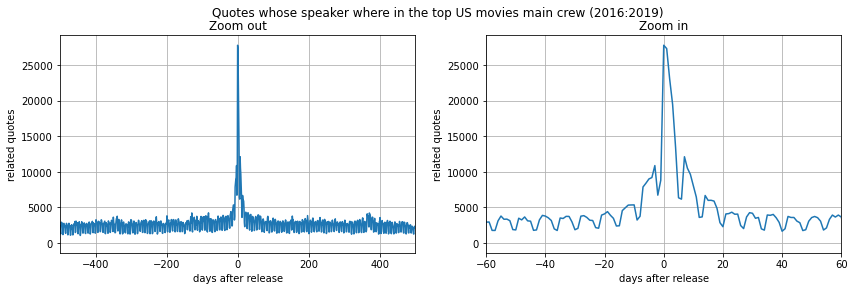

In [45]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
df_agg_tot = df_agg.groupby(["date_diff"]).sum()[["numOccurrences"]]
df_agg_tot = df_agg_tot.reset_index()
sb.lineplot(x="date_diff", y="numOccurrences", data=df_agg_tot)
plt.xlabel("days after release")
plt.ylabel("related quotes")
plt.title("Zoom out")
plt.grid()
plt.xlim(-500,500)

plt.subplot(1,2,2)
sb.lineplot(x="date_diff", y="numOccurrences", data=df_agg_tot)
plt.xlabel("days after release")
plt.ylabel("related quotes")
plt.grid()
plt.xlim(-60,60)
plt.title("Zoom in")
plt.suptitle(f"Quotes whose speaker where in the top US movies main crew ({START_YEAR+1}:{END_YEAR-1})")

plt.savefig(ASSETS_DIR + "quotes_around_release.png")

## 7 Correlation Box office - quotes counts

In [46]:
date_diff_treshold = 4
count_treshold = 10
df_agg_movie = df[(df["date_diff"].abs()<date_diff_treshold)].groupby(["primaryTitle"],as_index=False).agg({'primaryTitle': 'first', 'Total Gross': 'first','numOccurrences': 'count','Year':'first'})

df_agg_movie = df_agg_movie[df_agg_movie["numOccurrences"]>count_treshold]
df_agg_movie["log_numOccurrences"] = np.log(df_agg_movie["numOccurrences"])
df_agg_movie["log_Total Gross"] = np.log(df_agg_movie["Total Gross"])
df_agg_movie.head()

,primaryTitle,Total Gross,numOccurrences,Year,log_numOccurrences,log_Total Gross
1,12 Strong,45819713,259,2018.0,5.556828,17.640225
3,2.0,4152000,117,2018.0,4.762174,15.239101
4,20th Century Women,5664764,48,2017.0,3.871201,15.549776
5,21 Bridges,28539757,177,2019.0,5.176150,17.166809
7,47 Meters Down,44307191,167,2017.0,5.117994,17.606658


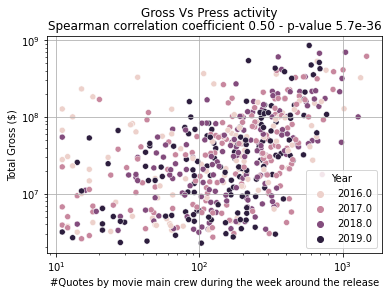

In [47]:
sb.scatterplot(x="numOccurrences",y="Total Gross",data=df_agg_movie,hue="Year")
plt.xlabel("#Quotes by movie main crew during the week around the release")
plt.ylabel("Total Gross ($)")
plt.yscale("log")
plt.xscale("log")
#Spearman Correlation
a = sc.stats.spearmanr(df_agg_movie["numOccurrences"],df_agg_movie["Total Gross"])

plt.title(f"Spearman correlation coefficient {a[0]:.2f} - p-value {a[1]:.1e}")
plt.suptitle("Gross Vs Press activity")
plt.grid()

plt.savefig(ASSETS_DIR + "gross_vs_occurrences.png")